In [ ]:
#set validation split = 0.2

#multiple convolutional layers, different filter sizes, different number of filters, multiple max pool layers,
#several dense layers, regularizers, dropout layers, different batch sizes or number of epochs;
#whatever gets you greater than 99%- 99.5% accuracy on the validation set.
#convolution = many small filters | multiple layers of convolution/maxpooling is usually helpful.

#For the transformer, you can use different hidden, key/query, and value dimensions, different number of heads for the MHSA layers, different number of layers

#Once you find two network structures that give you greater than 99% accuracy on the validation set, go back and train those networks on the entire training set.

#Plot a few of the numbers you misclassify from the test set.


In [ ]:
pip install tensorflow

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

%matplotlib inline

# Upload DataSet

11490434/11490434 [==============================] - 0s 0us/step


(0.0, 28.0, 0.0, 28.0)

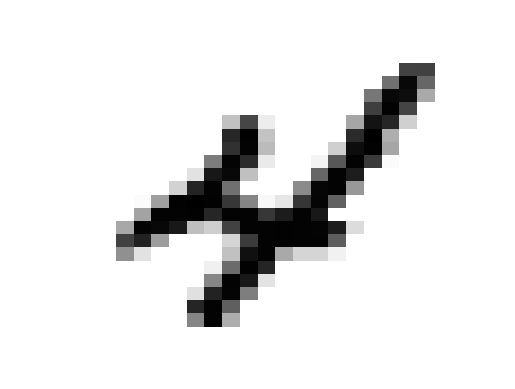

In [ ]:

mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test,y_test) = mnist.load_data()
x_train, x_test = x_train/255, x_test/255

ndata_train = x_train.shape[0]
ndata_test = x_test.shape[0]

plt.pcolor(1-x_train[9,::-1,:], cmap='gray')
plt.axis('off')

In [ ]:
#Reshaping it to 28x28x1

x_train = x_train.reshape((ndata_train,28,28,1))
x_test = x_test.reshape((ndata_test,28,28,1))

xshape = x_train.shape[1:4]
xshape

(28, 28, 1)

# ViT

In [ ]:
custom_optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001)

In [ ]:
class ClassToken(tf.keras.layers.Layer):
    def __init__(self):
        super().__init__()

    def build(self, input_shape):
        w_init = tf.random_normal_initializer()
        self.w = tf.Variable(
            initial_value = w_init(shape=(1, 1, input_shape[-1]), dtype=tf.float32),
            trainable = True
        )

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        hidden_dim = self.w.shape[-1]

        cls = tf.broadcast_to(self.w, [batch_size, 1, hidden_dim])
        cls = tf.cast(cls, dtype=inputs.dtype)
        return cls

In [ ]:
def build_ViT(n,m,block_size,hidden_dim,num_layers,num_heads,key_dim,mlp_dim,dropout_rate,num_classes):
    # n is number of rows of blocks
    # m is number of cols of blocks
    # block_size is number of pixels (with rgb) in each block

    inp = tf.keras.layers.Input(shape=(n*m,block_size)) #input subcuadrados de imagen
    inp2 = tf.keras.layers.Input(shape=(n*m)) #for positional embedding
    mid = tf.keras.layers.Dense(hidden_dim)(inp) # transform to vectors with different dimension
    # the positional embeddings
#     positions = tf.range(start=0, limit=n*m, delta=1)
    emb = tf.keras.layers.Embedding(input_dim=n*m, output_dim=hidden_dim)(inp2) # learned positional embedding for each of the n*m possible possitions
    mid = mid + emb # for some reason, tf.keras.layers.Add causes an error, but + doesn't?
    # create and append class token to beginning of all input vectors
    token = ClassToken()(mid) # append class token to beginning of sequence
    mid = tf.keras.layers.Concatenate(axis=1)([token, mid])

    for l in range(num_layers): # how many Transformer Head layers are there?
        ln  = tf.keras.layers.LayerNormalization()(mid) # normalize
        mha = tf.keras.layers.MultiHeadAttention(num_heads=num_heads,key_dim=key_dim,value_dim=key_dim)(ln,ln,ln) # self attention!
        add = tf.keras.layers.Add()([mid,mha]) # add and norm
        ln  = tf.keras.layers.LayerNormalization()(add)
        den = tf.keras.layers.Dense(mlp_dim,activation='gelu')(ln) # maybe should be relu...who knows...
        den = tf.keras.layers.Dropout(dropout_rate)(den) # regularization
        den = tf.keras.layers.Dense(hidden_dim)(den) # back to the right dimensional space
        den = tf.keras.layers.Dropout(dropout_rate)(den)
        mid = tf.keras.layers.Add()([den,add]) # add and norm again
    ln = tf.keras.layers.LayerNormalization()(mid)
    fl = ln[:,0,:] # just grab the class token for each image in batch
    clas = tf.keras.layers.Dense(num_classes,activation='softmax')(fl) # probability that the image is in each category
    mod = tf.keras.models.Model([inp,inp2],clas)
    mod.compile(optimizer=custom_optimizer2,loss='sparse_categorical_crossentropy',metrics=['accuracy'])
    return mod

In [ ]:
n = 4
m = 4
block_size = 49
hidden_dim = 96
num_layers = 6
num_heads = 4
key_dim = hidden_dim//num_heads # usually good practice for key_dim to be hidden_dim//num_heads...this is why we do Multi-Head attention
mlp_dim = hidden_dim
dropout_rate = 0.1
num_classes = 10

trans = build_ViT(n,m,block_size,hidden_dim,num_layers,num_heads,key_dim,mlp_dim,dropout_rate,num_classes)
trans.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 16, 49)]             0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 16)]                 0         []                            
                                                                                                  
 dense (Dense)               (None, 16, 96)               4800      ['input_1[0][0]']             
                                                                                                  
 embedding (Embedding)       (None, 16, 96)               1536      ['input_2[0][0]']             
                                                                                              

In [ ]:
x_train_ravel = np.zeros((ndata_train,n*m,block_size))
for img in range(ndata_train):
    ind = 0
    for row in range(n):
        for col in range(m):
            x_train_ravel[img,ind,:] = x_train[img,(row*7):((row+1)*7),(col*7):((col+1)*7)].ravel()
            ind += 1

In [ ]:
x_test_ravel = np.zeros((ndata_test,n*m,block_size))
for img in range(ndata_test):
    ind = 0
    for row in range(n):
        for col in range(m):
            x_test_ravel[img,ind,:] = x_test[img,(row*7):((row+1)*7),(col*7):((col+1)*7)].ravel()
            ind += 1

In [ ]:
pos_feed_train = np.array([list(range(n*m))]*ndata_train)
pos_feed_test = np.array([list(range(n*m))]*ndata_test)

In [ ]:
trans.fit([x_train_ravel,pos_feed_train],y_train,epochs=250,batch_size = 120,validation_split=0.2)

Epoch 1/250
400/400 [==============================] - 30s 29ms/step - loss: 0.6910 - accuracy: 0.7706 - val_loss: 0.1819 - val_accuracy: 0.9434
Epoch 2/250
400/400 [==============================] - 9s 23ms/step - loss: 0.1947 - accuracy: 0.9401 - val_loss: 0.1335 - val_accuracy: 0.9604
Epoch 3/250
400/400 [==============================] - 9s 23ms/step - loss: 0.1370 - accuracy: 0.9575 - val_loss: 0.1177 - val_accuracy: 0.9657
Epoch 4/250
400/400 [==============================] - 10s 26ms/step - loss: 0.1067 - accuracy: 0.9670 - val_loss: 0.0897 - val_accuracy: 0.9747
Epoch 5/250
400/400 [==============================] - 10s 24ms/step - loss: 0.0923 - accuracy: 0.9703 - val_loss: 0.0907 - val_accuracy: 0.9737
Epoch 6/250
400/400 [==============================] - 10s 25ms/step - loss: 0.0813 - accuracy: 0.9744 - val_loss: 0.0828 - val_accuracy: 0.9758
Epoch 7/250
400/400 [==============================] - 9s 22ms/step - loss: 0.0752 - accuracy: 0.9761 - val_loss: 0.0776 - val_accur

## Train with the whole data

In [ ]:
trans.fit([x_train_ravel,pos_feed_train],y_train,epochs=140,batch_size = 120,validation_split=0)


Epoch 1/140
500/500 [==============================] - 23s 47ms/step - loss: 0.0200 - accuracy: 0.9948
Epoch 2/140
500/500 [==============================] - 10s 21ms/step - loss: 0.0069 - accuracy: 0.9979
Epoch 3/140
500/500 [==============================] - 10s 21ms/step - loss: 0.0041 - accuracy: 0.9986
Epoch 4/140
500/500 [==============================] - 11s 22ms/step - loss: 0.0057 - accuracy: 0.9981
Epoch 5/140
500/500 [==============================] - 11s 21ms/step - loss: 0.0036 - accuracy: 0.9988
Epoch 6/140
500/500 [==============================] - 10s 21ms/step - loss: 0.0057 - accuracy: 0.9982
Epoch 7/140
500/500 [==============================] - 9s 19ms/step - loss: 0.0046 - accuracy: 0.9984
Epoch 8/140
500/500 [==============================] - 10s 20ms/step - loss: 0.0032 - accuracy: 0.9990
Epoch 9/140
500/500 [==============================] - 11s 23ms/step - loss: 0.0031 - accuracy: 0.9988
Epoch 10/140
500/500 [==============================] - 11s 22ms/step - lo

## Predict on test data

In [ ]:
out = trans.evaluate([x_test_ravel,pos_feed_test],y_test)
out

313/313 [==============================] - 6s 15ms/step - loss: 0.0610 - accuracy: 0.9880


[0.060979656875133514, 0.9879999756813049]

In [ ]:
pred_probs_vit = trans.predict([x_test_ravel,pos_feed_test])
pred_vit = np.argmax(pred_probs_vit, axis=1)
print(np.mean(pred_vit==y_test))

313/313 [==============================] - 5s 12ms/step
0.988


Number of misclassifications: 120
              precision    recall  f1-score   support

           1       0.99      0.99      0.99       980
           2       1.00      0.99      0.99      1135
           3       0.98      0.99      0.99      1032
           4       0.99      0.99      0.99      1010
           5       0.99      0.99      0.99       982
           6       0.99      0.98      0.99       892
           7       0.98      0.99      0.98       958
           8       0.99      0.99      0.99      1028
           9       0.99      0.99      0.99       974
          10       0.99      0.98      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



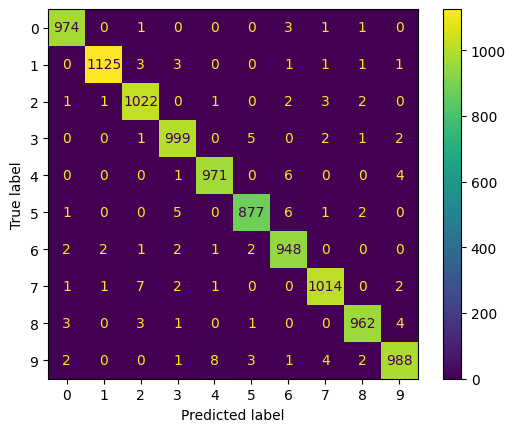

In [ ]:
print(f"Number of misclassifications: {np.sum(pred_vit != y_test)}")
print(classification_report(y_test, pred_vit, target_names=['1','2','3','4','5','6','7','8','9','10']))
# Plot confusion matrix
cm = confusion_matrix(y_test, pred_vit)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.arange(10))
disp.plot(cmap='viridis', values_format='d')

plt.show()

## Save

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
trans.save('drive/MyDrive/UT_AUSTIN/ViTmodel_mnist4')

In [ ]:
trans2 = tf.keras.models.load_model('drive/MyDrive/UT_AUSTIN/ViTmodel_mnist4')
pred_probs_vit2 = trans2.predict([x_test_ravel,pos_feed_test])
pred_vit2 = np.argmax(pred_probs_vit2, axis=1)
print(np.mean(pred_vit2==y_test))


313/313 [==============================] - 6s 16ms/step
0.988


## Missclasified examples

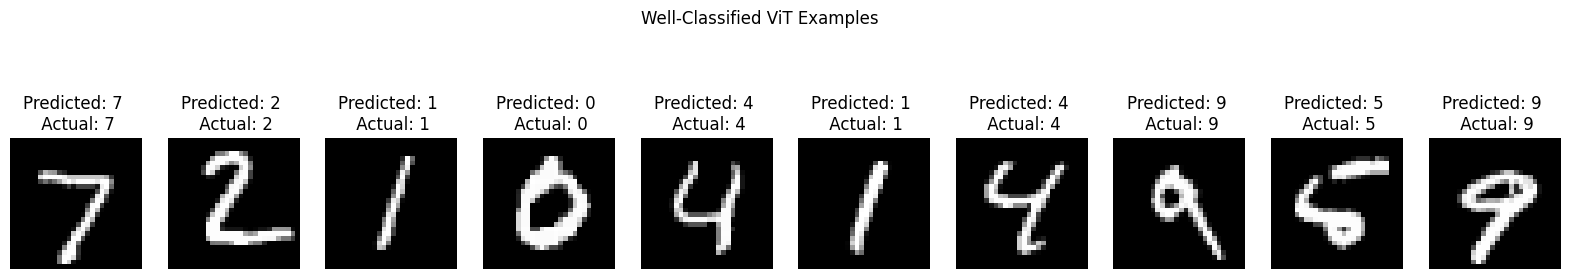

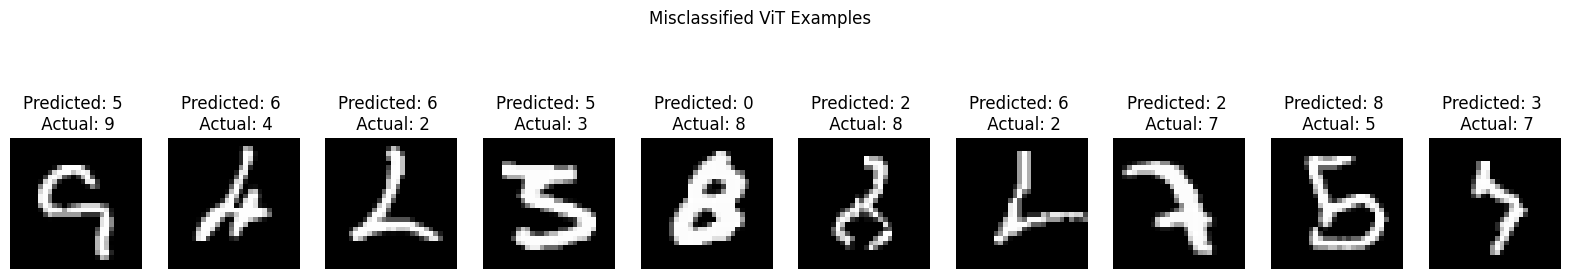

In [ ]:
well_classified_indices = np.where(pred_vit2 == y_test)[0]
misclassified_indices = np.where(pred_vit2 != y_test)[0]

# Plot well-classified examples
plt.figure(figsize=(20, 4))
for i, idx in enumerate(well_classified_indices[:10]):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {pred_vit2[idx]} \n Actual: {y_test[idx]}')
    plt.axis('off')
plt.suptitle('Well-Classified ViT Examples')
plt.show()

# Plot misclassified examples
plt.figure(figsize=(20, 4))
for i, idx in enumerate(misclassified_indices[:10]):
    plt.subplot(1, 10, i+1)
    plt.imshow(x_test[idx].reshape(28, 28), cmap='gray')
    plt.title(f'Predicted: {pred_vit2[idx]} \n Actual: {y_test[idx]}')
    plt.axis('off')
plt.suptitle('Misclassified ViT Examples')
plt.show()